In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import transforms
from torch.utils.data import Dataset
from typing import List, Tuple
import numpy as np
import copy
import os
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import torch.nn.functional as F
import random
import sys
sys.path.append('../')
from utils import BrainGraphDataset, project_root
from models import VGAE


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

# define the hyperparameters
input_dim = 100  # size of the graph adjacency matrix
hidden_dim = 256
latent_dim = 64
lr = 1e-3
batch_size = 64
num_epochs = 500

annotations = 'annotations.csv'
root = project_root()

dataroot = 'fc_matrices/psilo_ica_100_before/'
dataset = BrainGraphDataset(img_dir=os.path.join(root, dataroot),
                            annotations_file=os.path.join(root, annotations),
                            transform=None, extra_data=None, setting='lz')


# split the dataset into training and validation sets
num_samples = len(dataset)
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size

# set the random seed for reproducibility
torch.manual_seed(0)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# define the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# define a dictionary to store the loss curves for each configuration
loss_curves = {}

best_val_loss = float('inf')  # set to infinity to start
best_model_state = None
train_losses = []
val_losses = []

model = VGAE(1, 1, 100, 32, 8, device, dropout=0, l2_strength=0.001).to(device)  # move model to device
# model.load_state_dict(torch.load('vgae_nf_hcp_32_8.pt', map_location=device))
# print(model)
# src, dest = model.edge_index
# optimizer = optim.Adam(model.parameters(), lr=lr)

# for epoch in tqdm(range(num_epochs)):
#     train_loss = 0.0
#     val_loss = 0.0

#     # training
#     model.train()
#     for batch_idx, ((graph, lz, _), _) in enumerate(train_loader):
#         graph = graph.to(device)  # move data to device
#         lz = lz.to(device)
#         optimizer.zero_grad()

#         rcn_lz, rcn_edges, z, mu, logvar = model(lz, graph)
#         graph = graph[:, src, dest]

#         (mse_x, mse_edges, kl_loss, l2_reg) = model.loss(rcn_lz.view(lz.shape), lz, rcn_edges.view(graph.shape), graph,
#                                                          mu, logvar)
#         loss = mse_x + mse_edges  + kl_loss + l2_reg
#         loss.backward()
#         optimizer.step()
#         train_loss += mse_edges.item()

#     # validation
#     model.eval()
#     with torch.no_grad():
#         for batch_idx, ((graph, lz, _), _) in enumerate(val_loader):
#             graph = graph.to(device)  # move data to device
#             lz = lz.to(device)

#             rcn_lz, rcn_edges, z, mu, logvar = model(lz, graph)
#             graph = graph[:, src, dest]

#             (mse_x, mse_edges, kl_loss, l2_reg) = model.loss(rcn_lz.view(lz.shape), lz, rcn_edges.view(graph.shape), graph,
#                                                              mu, logvar)
#             loss = mse_x + mse_edges  + kl_loss + l2_reg
#             val_loss += mse_edges.item()
#     # append losses to lists
#     train_losses.append(train_loss/len(train_dataset))
#     val_losses.append(val_loss/len(val_dataset))

#     if (epoch + 1) % 20 == 0:
#         print(train_losses[-1], val_losses[-1])
#     # save the model if the validation loss is at its minimum
#     if val_losses[-1] < best_val_loss:
#         best_val_loss = val_losses[-1]
#         best_model_state = copy.deepcopy(model.state_dict())

# # save the best model for this configuration
# torch.save(best_model_state, os.path.join(root, f'vgae_weights/vgae_nf_fine_tune.pt'))
model.load_state_dict(torch.load(os.path.join(root, f'vgae_weights/vgae_nf_fine_tune.pt'), map_location=device))

cpu


<All keys matched successfully>

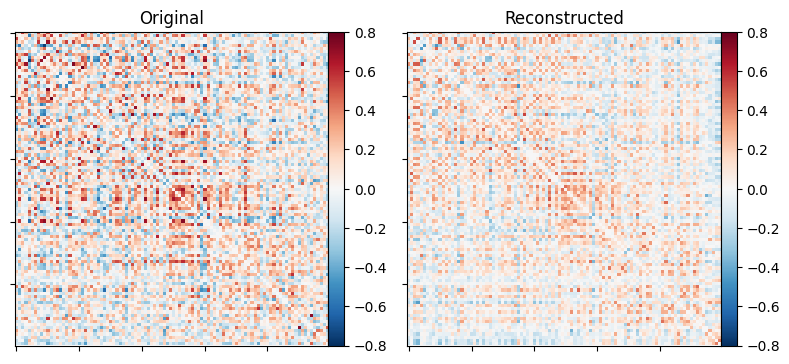

In [3]:
import matplotlib.pyplot as plt
from nilearn import plotting

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_samples = len(dataset)
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size

# set the random seed for reproducibility
torch.manual_seed(0)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# define the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model = VGAE(1, 1, 100, 64, 4, device, dropout=0, l2_strength=0.001).to(device)

# load the weights
model.load_state_dict(torch.load(os.path.join(root, f'vgae_weights/vgae_nf_ica.pt'), map_location=device))

# select a batch from the validation data loader
data, _ = next(iter(val_loader))

for j in range(min(batch_size, 1)):
    # pass the batch through the trained model to obtain the reconstructed output
    (graph, lz, _) = data
    graph = graph[j:j+1].to(device)
    lz = lz[j:j+1].to(device)

    rcn_lz, recon_edges, z, mu, logvar = model(lz, graph)

    recon_edges = recon_edges.detach()

    # Create a SparseTensor object from the edge_index and edge_attr tensors
    recon = torch.zeros((100, 100))

    edge_index = model.edge_index
    for i in range(edge_index.shape[1]):
        recon[edge_index[0,i], edge_index[1,i]] = recon_edges[0][i]
        recon[edge_index[1,i], edge_index[0,i]] = recon_edges[0][i]

    # reshape the output to a 100x100 matrix (assuming the input_dim is 100x100)

    # plot the original and reconstructed matrices for the first sample in the batch
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    plotting.plot_matrix(graph.cpu().view(100, 100), colorbar=True, vmax=0.8, vmin=-0.8, axes=ax1)
    ax1.set_title('Original')
    plotting.plot_matrix(recon.detach(), colorbar=True, vmax=0.8, vmin=-0.8, axes=ax2)
    ax2.set_title('Reconstructed')
    plt.savefig('recon_vgae_nf_fine_tune.png')
    plt.show()

In [4]:
# load in the models and get the validation loss for each

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

models = []
test_losses = []

# set the model to evaluation mode
model.eval()

src, dest = model.edge_index
# calculate the validation loss
val_loss = 0.0
with torch.no_grad():
    for batch_idx, ((graph, lz, _), _) in enumerate(val_loader):
        graph = graph.to(device)  # move data to device
        lz = lz.to(device)

        rcn_lz, rcn_edges, z, mu, logvar = model(lz, graph)
        graph = graph[:, src, dest]

        (mse_x, mse_edges, im_loss, l2_reg) = model.loss(rcn_lz.view(lz.shape), lz, rcn_edges.view(graph.shape), graph, mu, logvar)
        loss = mse_x + mse_edges + l2_reg
        val_loss += mse_edges.item()

print(val_loss / len(val_dataset))

150.78097873263889


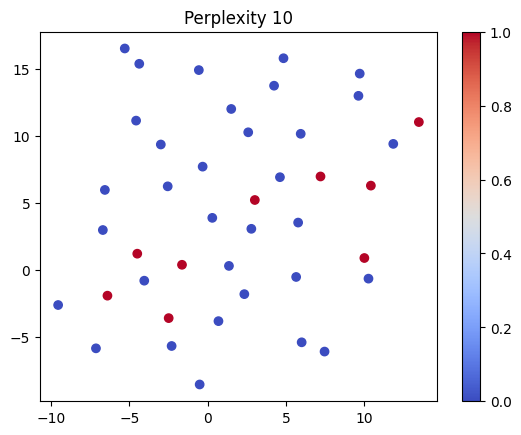

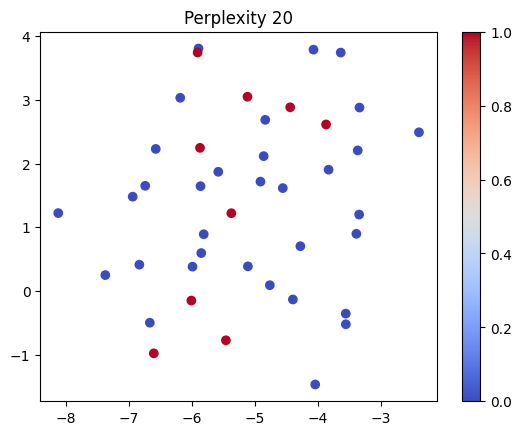

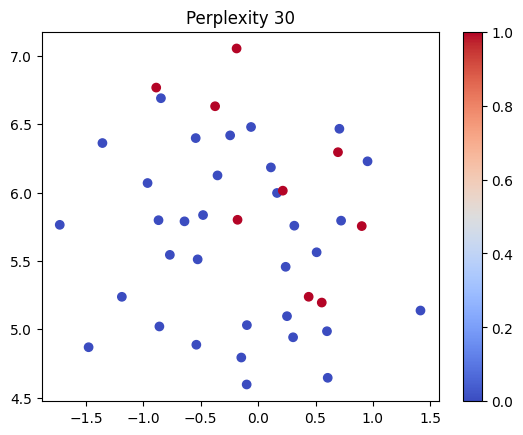

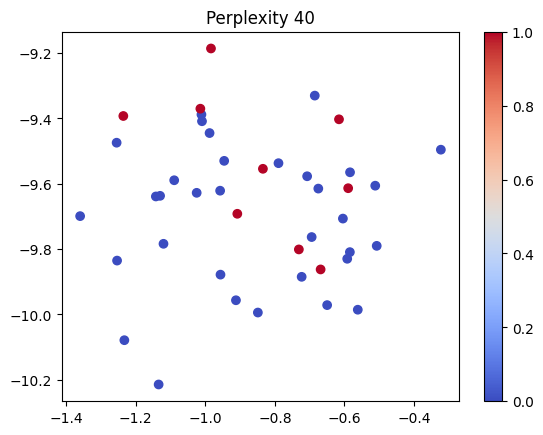

In [5]:
# load in the models and get the validation loss for each

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_samples = len(dataset)
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size

# set the random seed for reproducibility
torch.manual_seed(0)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# define the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model = VGAE(1, 1, 100, 64, 4, device, dropout=0, l2_strength=0.001).to(device)
# load the weights
model.load_state_dict(torch.load(os.path.join(root, f'vgae_weights/vgae_nf_ica.pt'), map_location=device))

psilo_zs = []
hcp_zs = []

with torch.no_grad():
    for batch_idx, ((graph, lz, _), _) in enumerate(train_loader):
        _, _, z, _, _ = model(graph, lz)
        psilo_zs.append(z)

    for batch_idx, ((graph, lz, _), _) in enumerate(val_loader):
        _, _, z, _, _ = model(graph, lz)
        hcp_zs.append(z)

psilo_zs = torch.cat(psilo_zs, dim=0)
hcp_zs = torch.cat(hcp_zs, dim=0)

# Concatenate the encoded representations and create labels
x = torch.cat((psilo_zs, hcp_zs), dim=0)
labels = torch.cat((torch.zeros(psilo_zs.shape[0]), torch.ones(hcp_zs.shape[0])), dim=0)

from sklearn.manifold import TSNE

for per in [10, 20, 30, 40]:
    # Use t-SNE to reduce the dimensionality of the encoded representations
    tsne = TSNE(n_components=2, perplexity=per, n_iter=1000)
    x_tsne = tsne.fit_transform(x)

    # Plot the t-SNE embeddings
    plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=labels, cmap='coolwarm')
    plt.colorbar()
    plt.title(f'Perplexity {per}')
    plt.savefig(f'tsne-vgae-nf-{per}.png', bbox_inches='tight')
    plt.show()